In [2]:
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [5]:
def int_to_64bit_list(number):
    binary_str = format(number, '064b')
    return [int(bit) for bit in binary_str]

In [6]:
function = lambda x: math.sin(x)

ints = [x for x in range(1, 100_000)]

input_data = [int_to_64bit_list(x) for x in ints]
output_labels = [function(x) for x in ints]

In [8]:
class Data(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.labels = outputs

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()  
        self.layer1 = nn.Linear(64, 64 * 5) # 64 bits in
        self.layer2 = nn.Linear(64 * 5, 64 * 10)  
        self.output = nn.Linear(64 * 10, 1) # 64 bits out

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output(x)
        return x

In [181]:
training_dataset = Data(input_data, output_labels)
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)

model = Model().to(device)

loss = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(50):
    for data in training_loader:
        inputs, labels = data
        labels = labels.view(-1, 1)
        optimizer.zero_grad()
        out = model(inputs.to(device))
        loss_size = loss(out, labels.to(device))
        loss_size.backward()
        optimizer.step()

    print(f"Loss: {loss_size}")

torch.save(model.state_dict(), "model")

Loss: 0.5203452706336975
Loss: 0.537867546081543
Loss: 0.5687859654426575
Loss: 0.5748502612113953
Loss: 0.477509081363678
Loss: 0.39628034830093384
Loss: 0.07464863359928131
Loss: 0.05374307185411453
Loss: 0.0495455376803875
Loss: 0.020435582846403122
Loss: 0.04044293239712715
Loss: 0.010281447321176529
Loss: 0.00950159877538681
Loss: 0.011789032258093357
Loss: 0.028798924759030342
Loss: 0.00361211271956563
Loss: 0.0035207923501729965
Loss: 0.007657609414309263
Loss: 0.004893044009804726
Loss: 0.006681011524051428
Loss: 0.010199647396802902
Loss: 0.001999662956222892
Loss: 0.010047278366982937
Loss: 0.016984721645712852
Loss: 0.006052306387573481
Loss: 0.004431175533682108
Loss: 0.0037989444099366665
Loss: 0.013352916575968266
Loss: 0.03390971198678017
Loss: 0.035503167659044266
Loss: 0.0015753427287563682
Loss: 0.001956128515303135
Loss: 0.026555636897683144
Loss: 0.0016077703330665827
Loss: 0.004002026282250881
Loss: 0.0019036629237234592
Loss: 0.002629634225741029
Loss: 0.003770967

In [10]:
def percentage_difference(a, b):
    return abs(a - b) / ((a + b) / 2) * 100#

checkpoint = torch.load("model")
model = Model().to(device)
model.load_state_dict(checkpoint)

for i in range(20):
  with torch.no_grad():
    val = torch.tensor(input_data[i], dtype=torch.float32).to(device)
    answer = torch.tensor(output_labels[i], dtype=torch.float32).to(device)

    outputs = model(val)  # Get predictions from the model.
    print(f"approx: {outputs.data.item()}")
    print(f"answer: {answer}")

    print(f"percentage difference: {percentage_difference(outputs.data.item(), answer)}%")

approx: 0.8269626498222351
answer: 0.8414709568023682
percentage difference: 1.7391530275344849%
approx: 0.9084844589233398
answer: 0.9092974066734314
percentage difference: 0.08944392204284668%
approx: 0.14180268347263336
answer: 0.14112000167369843
percentage difference: 0.48259249329566956%
approx: -0.7345138788223267
answer: -0.756802499294281
percentage difference: -2.9891204833984375%
approx: -1.0075446367263794
answer: -0.9589242935180664
percentage difference: -4.944938659667969%
approx: -0.2705501317977905
answer: -0.279415488243103
percentage difference: -3.2239675521850586%
approx: 0.6830933690071106
answer: 0.6569865942001343
percentage difference: 3.896300792694092%
approx: 0.9983935356140137
answer: 0.9893582463264465
percentage difference: 0.909096360206604%
approx: 0.4112817049026489
answer: 0.41211849451065063
percentage difference: 0.20325224101543427%
approx: -0.5268750786781311
answer: -0.5440211296081543
percentage difference: -3.2021872997283936%
approx: -0.994722

/var/folders/42/sx5nf5k12qs453xv_z7qx_nw0000gn/T/ipykernel_49240/433370342.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model")


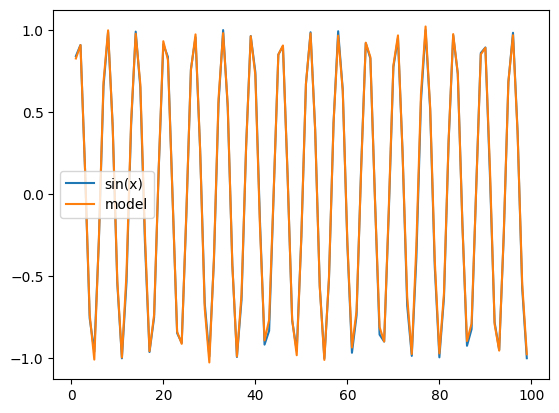

In [14]:
# plot both the function and the model approximation with matplotlib
import matplotlib.pyplot as plt


x = [x for x in range(1, 100)]
y = [function(x) for x in x]

y2 = []
for i in range(1, 100):
    val = torch.tensor(int_to_64bit_list(i), dtype=torch.float32).to(device)
    outputs = model(val)
    y2.append(outputs.data.item())

# how to clean this plot up so it is smoother
plt.plot(x, y, label="sin(x)")
plt.plot(x, y2, label="model")

plt.legend()

plt.show()
